# Using semi-supervise approach
#### borrow random forest model to guess the missing NaN values 

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
import graphviz

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Load data

In [3]:
phishing_data = pd.read_csv('phishing_final.csv')
resultTarget = phishing_data["Result"]
# resultTarget.value_counts().argmax()

In [4]:
# make copy versions:
# dataframe that will apply semi-suppervised learning to replace NaN
phishingWithRFReplacement = phishing_data.copy(deep=True)


# Understanding dataset

In [5]:
# Display first 5 sample rows of data
phishing_data.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,Yes,Medium,No,NaN,Yes,No,More than one,Short,Yes,Yes,Yes,Yes,Medium,Medium,Empty,Yes,Yes,No,No,Yes,No,Yes,Short,No,Medium,NaN,Yes,Two links and above,Reported,Phish
1,No,Medium,No,Yes,No,No,More than one,Short,Yes,Yes,No,Yes,Medium,Medium,Empty,No,No,No,Yes,Yes,Yes,Yes,Long,Yes,High,Low,Yes,No links,Not reported,Phish
2,Yes,Medium,No,Yes,Yes,No,More than one,Short,Yes,Yes,No,Yes,Medium,High,NaN,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,No,NaN,High,Yes,Some links,Reported,Phish
3,Yes,NaN,Yes,NaN,Yes,No,One,Long,Yes,Yes,Yes,No,Medium,Medium,Empty,No,No,No,Yes,Yes,Yes,Yes,Short,Yes,High,High,Yes,No links,Not reported,Phish
4,Yes,Long,No,Yes,Yes,Yes,None,Short,Yes,Yes,No,Yes,Medium,NaN,Some,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,No,High,Low,Yes,No links,Reported,Phish


In [6]:
# A summary table of the dataset
phishing_data.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055,9947,9937,9957,9952,11055,11055,11055,11055,11055,9972,9976,9956,9948,9977,9950,11055,11055,11055,11055,11055,11055,9971,9934,9941,9982,9961,11055,11055,10001
unique,2,3,2,2,2,2,3,2,2,2,2,2,3,3,3,2,2,2,2,2,2,2,2,2,3,2,2,3,2,2
top,Yes,Short,Yes,Yes,Yes,No,More than one,Short,Yes,Yes,Yes,Yes,Medium,Medium,Empty,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,Yes,High,Low,Yes,Some links,Reported,Phish
freq,7262,8078,8641,8474,8649,9590,4070,7389,9002,9553,8335,5908,4833,4021,7602,8126,9426,9776,9740,10579,8918,10043,5316,6832,5244,7382,8562,6156,9505,5560


In [7]:
# Number of rows with NaN result
print(f'Number of rows without the result: {phishing_data[phishing_data.Result.isnull()].shape[0]}')

Number of rows without the result: 1054


## Observation

Result has NaN => dont know the outcome => drop row

Several columns have NaN result

In [8]:
# drop unknown result:
phishing_data = phishing_data[~phishing_data['Result'].isnull()]
phishing_data.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,Yes,Medium,No,NaN,Yes,No,More than one,Short,Yes,Yes,Yes,Yes,Medium,Medium,Empty,Yes,Yes,No,No,Yes,No,Yes,Short,No,Medium,NaN,Yes,Two links and above,Reported,Phish
1,No,Medium,No,Yes,No,No,More than one,Short,Yes,Yes,No,Yes,Medium,Medium,Empty,No,No,No,Yes,Yes,Yes,Yes,Long,Yes,High,Low,Yes,No links,Not reported,Phish
2,Yes,Medium,No,Yes,Yes,No,More than one,Short,Yes,Yes,No,Yes,Medium,High,NaN,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,No,NaN,High,Yes,Some links,Reported,Phish
3,Yes,NaN,Yes,NaN,Yes,No,One,Long,Yes,Yes,Yes,No,Medium,Medium,Empty,No,No,No,Yes,Yes,Yes,Yes,Short,Yes,High,High,Yes,No links,Not reported,Phish
4,Yes,Long,No,Yes,Yes,Yes,None,Short,Yes,Yes,No,Yes,Medium,NaN,Some,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,No,High,Low,Yes,No links,Reported,Phish


In [9]:
phishing_data.shape

(10001, 30)

In [10]:
phishing_data.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,10001,8990,8974,9019,8987,10001,10001,10001,10001,10001,9019,9028,9007,8993,9027,8997,10001,10001,10001,10001,10001,10001,9029,8991,8988,9041,9008,10001,10001,10001
unique,2,3,2,2,2,2,3,2,2,2,2,2,3,3,3,2,2,2,2,2,2,2,2,2,3,2,2,3,2,2
top,Yes,Short,Yes,Yes,Yes,No,More than one,Short,Yes,Yes,Yes,Yes,Medium,Medium,Empty,Yes,Yes,No,Yes,Yes,Yes,Yes,Long,Yes,High,Low,Yes,Some links,Reported,Phish
freq,6567,7285,7811,7686,7810,8664,3688,6662,8142,8641,7546,5343,4371,3635,6892,7373,8543,8835,8799,9561,8070,9070,4816,6186,4741,6691,7728,5551,8595,5560


some missing data: 8974 ~ 10001

## Visualize the original dataframe

<Figure size 432x288 with 0 Axes>

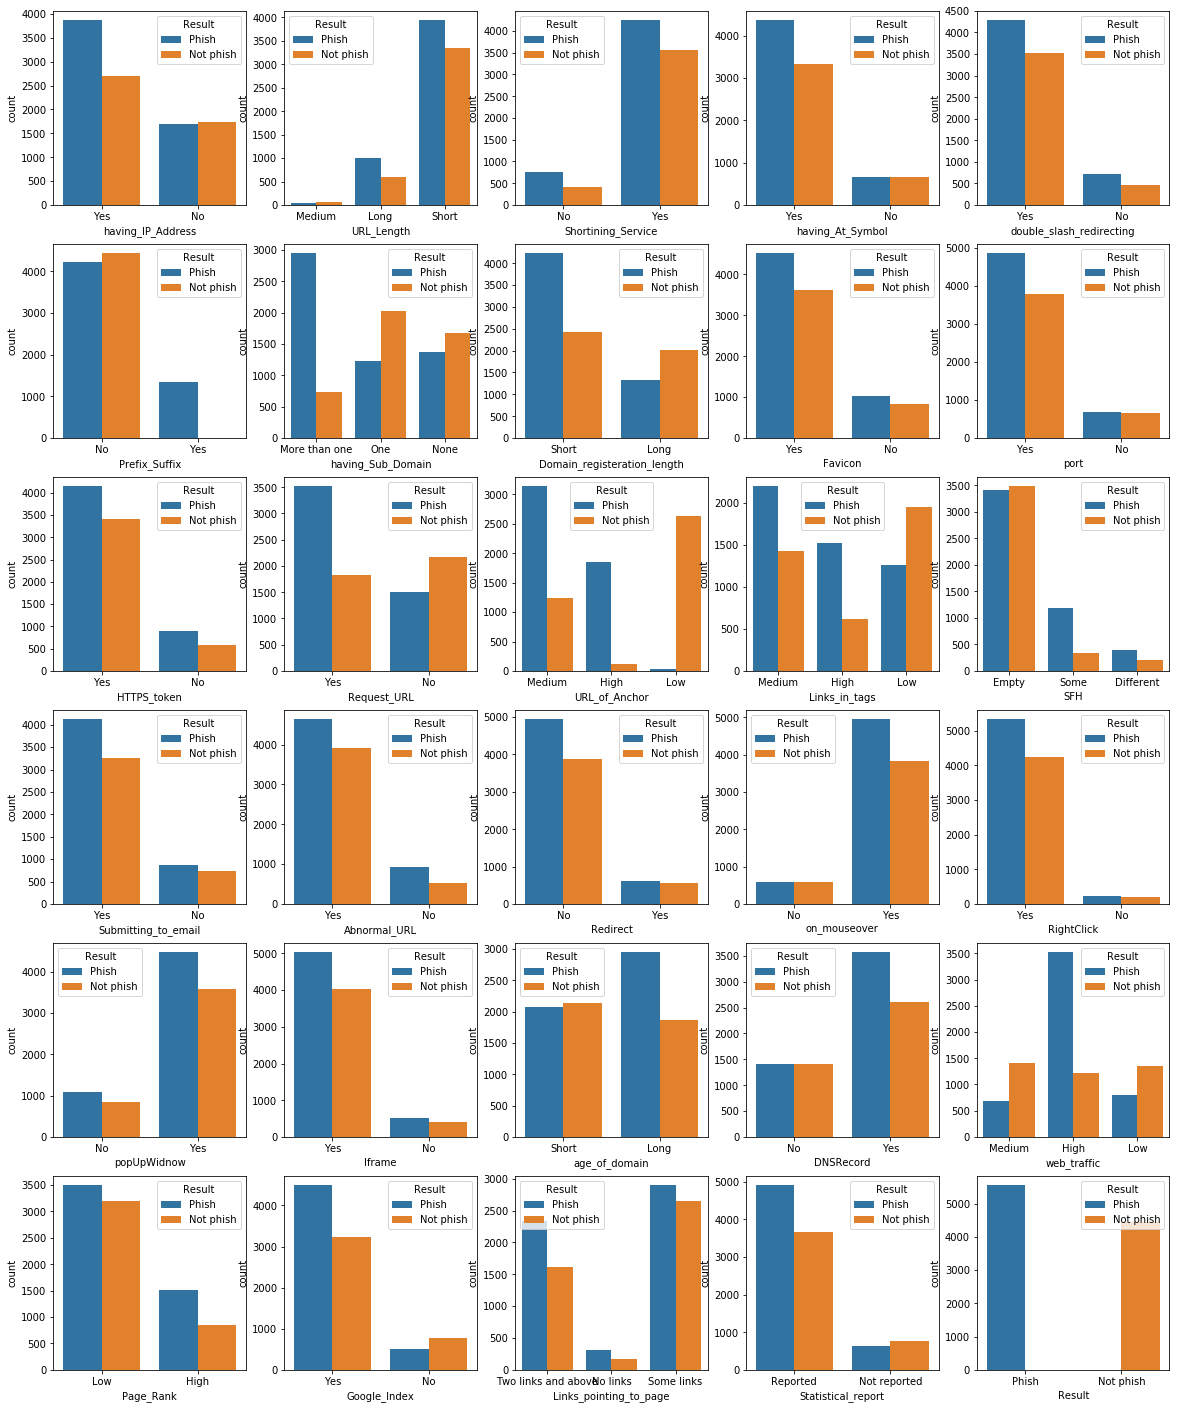

In [12]:
columns_plot = np.array(phishing_data.columns).reshape(6, 5)
plt.subplots_adjust(left  = 0.3, right = 0.9, bottom = 0.2, top = 0.9, wspace = 0.3, hspace = 0.3)

f, axes = plt.subplots(6, 5, figsize=(20, 25))
for x in range(6):
    for y in range(5):
        sns.countplot(x=columns_plot[x][y], hue='Result', data=phishing_data, ax=axes[x][y])

## from data distribution:
    Data is not bias.
    first layer entropy important features: 
        URL-Anchor, Prefix, LinkinTag, webTrafic, DomainLength...

# Preprocess 

## using semi-supervised technic
### RandomForestClassifier helper model

In [14]:
# function to get column names which contain NaN values
def columnsContainNaN (df):
    result = df.columns[df.isna().any()].tolist()
    return result
# columnsContainNaN(phising_data)

In [15]:
columnsContainNaN(phishingWithRFReplacement)

['URL_Length',
 'Shortining_Service',
 'having_At_Symbol',
 'double_slash_redirecting',
 'HTTPS_token',
 'Request_URL',
 'URL_of_Anchor',
 'Links_in_tags',
 'SFH',
 'Submitting_to_email',
 'age_of_domain',
 'DNSRecord',
 'web_traffic',
 'Page_Rank',
 'Google_Index',
 'Result']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [39]:
# encoding labels
# to avoid side-effect on the input dataframe, make a deep copy
def encodingDF (df):    
    dataframe = df
    for column in dataframe.columns.tolist() :
        dataframe[column] = LabelEncoder().fit_transform(dataframe[column])      
    return dataframe


In [40]:
# get rows of dataframe that contains NaN in some columns
nanRows = lambda df,columns: df[df[columns].isnull().any(axis=1)]
# get dataframe that drops all rows contain NaN at some columns
hasValuesRows = lambda df,columns: df[~df[columns].isnull().any(axis=1)]

# URLLenghtTrainingSet = hasValuesRows(phising_data,["URL_Length"])
# URLLenghtGuessingSet = nanRows(phising_data,["URL_Length"])

In [41]:
# function to split data into two set: trainingSet that rows do not contain NaN; guessingSet does
# param column: the column to reference value to split
def splitNaNByColumn (df, column):
    TrainingSet = hasValuesRows(df,[column])
    GuessingSet = nanRows(df,[column])
    return (TrainingSet,GuessingSet)

In [42]:
# function to fill NaN with a certain value:
def fillNaN (df, value):    
    for column in df.columns.tolist() :
        df[column] = df[column].fillna(value)
    return df
# fillNaN(phising_data.drop("URL_Length", axis=1),"default")

In [43]:
# function to use RandomForestClassifier model to fill in NaN values of one target column
# param: 
#      df: dataframe contain the column
#      column: the column that will clean up NaN value 
def useModelFillNaN (df,column):
#     spliting target, features
    target = df[column]
#     print(target)
    remainFeatures = df.drop(columns=[column])
#     fill nan features by default label, that helps RFC model to work
    remainFeatures = fillNaN(remainFeatures,"default")
#     print(column in remainFeatures.columns.tolist())
#     combine
    dataframe = remainFeatures.join(target)
#     split train-guess sets
    (train,guess) = splitNaNByColumn(dataframe,column)
#     print(guess)
    if guess.empty != True:
#     split X-Y and transform data: 
        trainX,trainY = encodingDF(train.drop(columns=[column])), train[column]
#     train model :
        RFC = RandomForestClassifier().fit(trainX, trainY)
#     guess missing data:
        missingData = RFC.predict(encodingDF(guess.drop(columns = [column])))
        guess[column] = missingData
        dataframe = train.append(guess)
#     convert back to original NaN for further work (to avoid side effect)
    dataframe.replace("default", np.nan)
    return dataframe.replace("default", np.nan)
# useModelFillNaN(phising_data,'URL_Length')    
    

In [46]:
# just wrap the name
dataFrameRF = phishingWithRFReplacement
# excepth result column, fill all NaN in the dataframe using RFT model
for column in columnsContainNaN(dataFrameRF):
#     avoid fill the result column
    if column != "Result" :
        dataFrameRF = useModelFillNaN(dataFrameRF,column) 


/Users/donbosco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/donbosco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/donbosco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/donbosco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

/Users/donbosco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/donbosco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
# check result
print(dataFrameRF)

      having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
0                   Yes     Medium                 No              NaN   
1                    No     Medium                 No              Yes   
2                   Yes     Medium                 No              Yes   
3                   Yes        NaN                Yes              NaN   
4                   Yes       Long                 No              Yes   
5                   Yes       Long                Yes              Yes   
6                   Yes       Long                Yes              Yes   
7                   Yes     Medium                 No              Yes   
8                   Yes     Medium                Yes              Yes   
9                   Yes       Long                Yes              Yes   
10                  Yes       Long                Yes              Yes   
11                  Yes      Short                 No               No   
12                  Yes      Short    

In [47]:
# check if dataframe target remain untouch
columnsContainNaN(dataFrameRF)

['Result']

# Split data

In [48]:
# drop unknown result:
dataFrameRF = dataFrameRF[~dataFrameRF['Result'].isnull()]

In [49]:
# split features and target
# the dataframe that use random forest suggestion method
phishingRF_X, phishingRF_y =  dataFrameRF.drop('Result', axis=1), dataFrameRF['Result']


In [50]:
trainRF_X, testRF_X, trainRF_y, testRF_y = train_test_split(encodingDF(phishingRF_X), 
            phishingRF_y, test_size=0.3, stratify = phishingRF_y, random_state=42)
# todo: check best test_size

### first train and evaluate

#### work with Random forest suggestion dataframe

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [53]:
clf_rand = RandomForestClassifier().fit(trainRF_X, trainRF_y)
clf_ada = AdaBoostClassifier().fit(trainRF_X, trainRF_y)
clf_bagging = BaggingClassifier().fit(trainRF_X, trainRF_y)
clf_grad= GradientBoostingClassifier().fit(trainRF_X, trainRF_y)
clf_tree = DecisionTreeClassifier().fit(trainRF_X, trainRF_y)

/Users/donbosco/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [54]:
predictions_rand = clf_rand.predict(testRF_X)
predictions_ada = clf_ada.predict(testRF_X)
predictions_bagging = clf_bagging.predict(testRF_X)
predictions_grad = clf_grad.predict(testRF_X)
predictions_tree = clf_tree.predict(testRF_X)

In [56]:
from sklearn.metrics import classification_report

In [57]:
print("random forest classifier : \n",classification_report(testRF_y, predictions_rand))
print("ada classifier : \n",classification_report(testRF_y, predictions_ada))
print("bagging classifier : \n",classification_report(testRF_y, predictions_bagging))
print("grad classifier : \n",classification_report(testRF_y, predictions_grad))
print("tree classifier : \n",classification_report(testRF_y, predictions_tree))

random forest classifier : 
               precision    recall  f1-score   support

   Not phish       0.94      0.95      0.95      1333
       Phish       0.96      0.96      0.96      1668

   micro avg       0.95      0.95      0.95      3001
   macro avg       0.95      0.95      0.95      3001
weighted avg       0.95      0.95      0.95      3001

ada classifier : 
               precision    recall  f1-score   support

   Not phish       0.92      0.88      0.90      1333
       Phish       0.91      0.94      0.92      1668

   micro avg       0.91      0.91      0.91      3001
   macro avg       0.91      0.91      0.91      3001
weighted avg       0.91      0.91      0.91      3001

bagging classifier : 
               precision    recall  f1-score   support

   Not phish       0.93      0.95      0.94      1333
       Phish       0.96      0.94      0.95      1668

   micro avg       0.95      0.95      0.95      3001
   macro avg       0.95      0.95      0.95      3001
wei

In [61]:
from sklearn import metrics

In [62]:
def scoreClassifier(model,testX,testY):
    print("accuracy score: ",metrics.accuracy_score(testY,model.predict(testX)))
    print("roc auc score: ",metrics.roc_auc_score(testY,model.predict_proba(testX)[:, 1]))
    

In [63]:
scoreClassifier(clf_rand,testRF_X,testRF_y)

accuracy score:  0.9536821059646784
roc auc score:  0.9851918914980544


### further examine result

In [65]:
def predictProbability(classifyModel,testFeatures):
    y_pred_prob = classifyModel.predict_proba(testFeatures)[:, 1]
    plt.rcParams['font.size'] = 8
    plt.hist(y_pred_prob, bins=10)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability')
    plt.ylabel('Frequency')


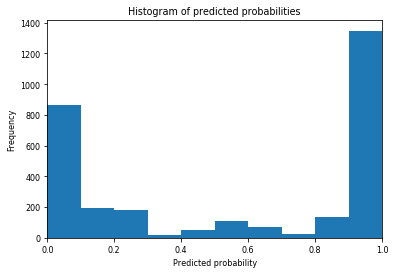

In [66]:
predictProbability(clf_rand,testRF_X)

#### check the importance features

No handles with labels found to put in legend.


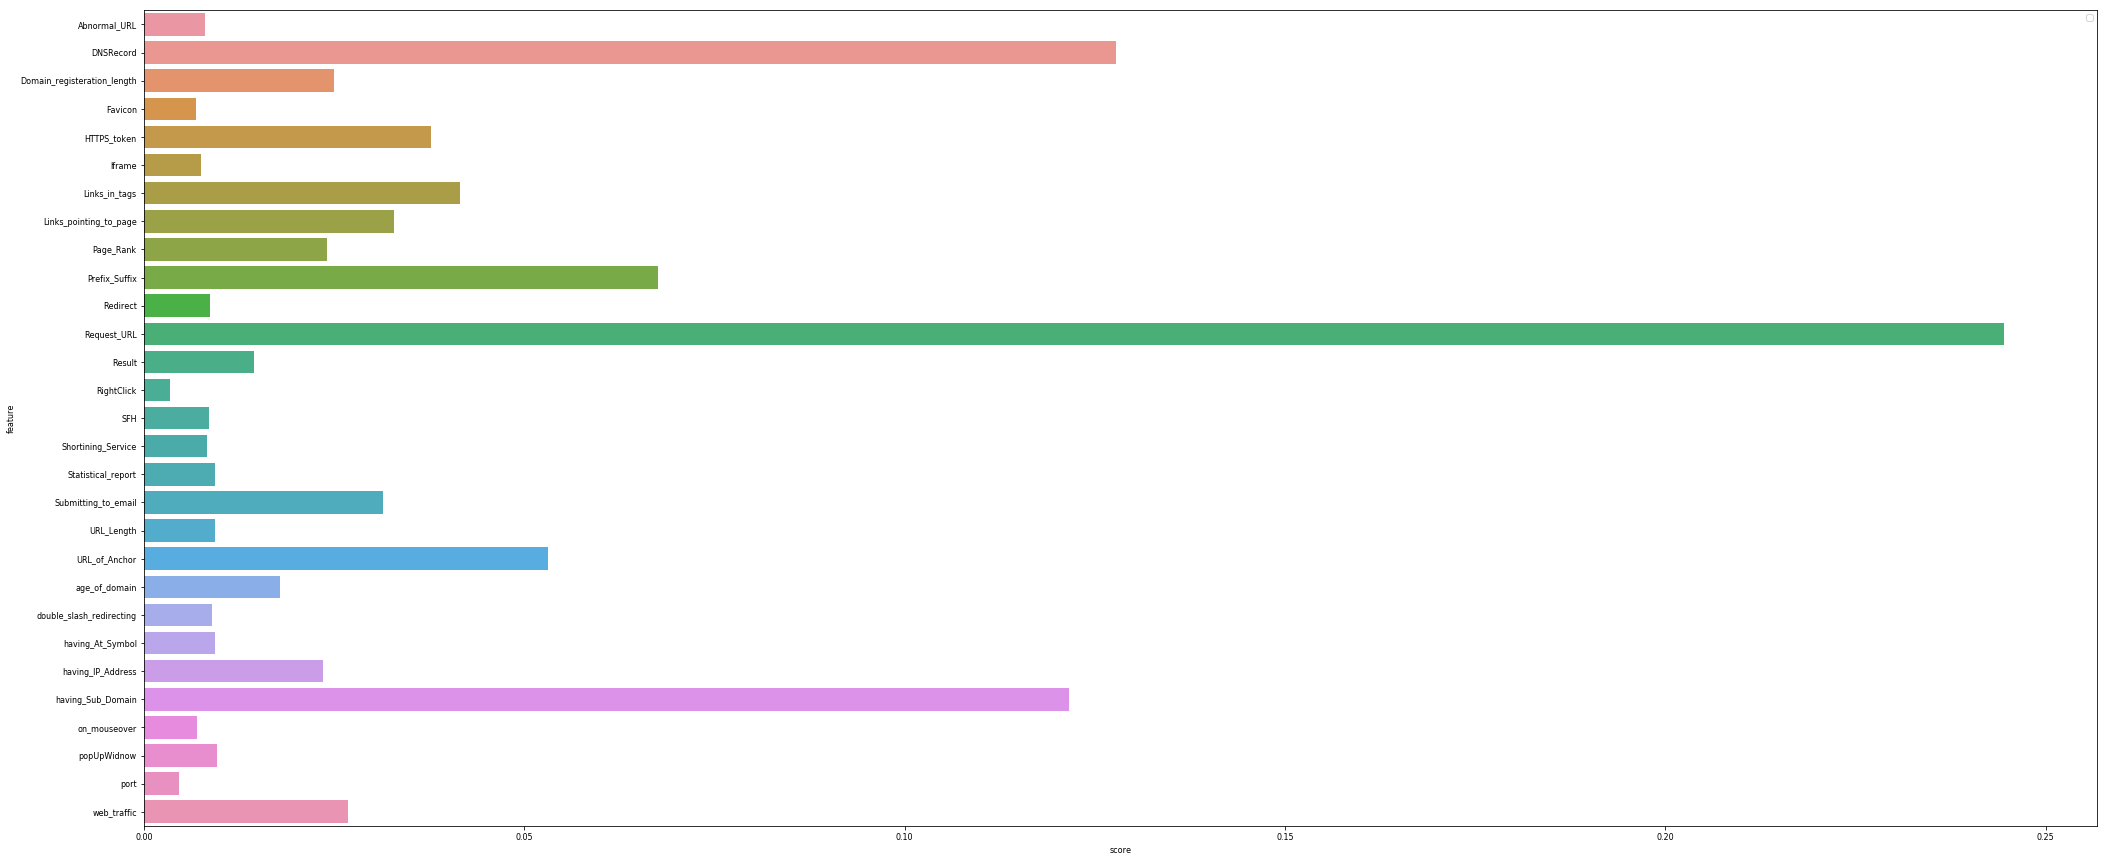

In [67]:
# suggestions from random forest tree
fi_rand = pd.DataFrame(sorted(zip(dataFrameRF.columns,
                            map(lambda x: round(x, 4), clf_rand.feature_importances_))), 
                       columns=['feature', 'score'])
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.barplot(x='score', y='feature', data=fi_rand, ax=ax)
ax.legend()

In [68]:
# fi_rand = fi_rand.sort_values(by="score",ascending=False)
# # drop the Result
# fi_rand_filted = list(filter(lambda item: item != "Result", fi_rand["feature"].ravel()))
# fi_rand_filted

### features selection:
with default decision tree setting

In [70]:
# function to train a model with train and test set, with selected features
# params:
#     model: model want to train (here we use classifier models)
#     trainX,trainY,testX,testY: dataframe
#     features: features that the model will be trained on
# output: 
#     trained model and evaluation report
def trainAndReportWithFeatures(model, trainX,trainY,testX,testY,features):
    trainedModel = model.fit(trainX[features],trainY)
    predictions = trainedModel.predict(testX[features])
#     report = classification_report(testY, predictions, output_dict=True)
    report = classification_report(testY, predictions)
    accuracy = metrics.accuracy_score(testY,predictions)
    rocAuc = metrics.roc_auc_score(testY,trainedModel.predict_proba(testX[features])[:, 1])
#     print(report)
    return (trainedModel,report,accuracy,rocAuc)


In [71]:
# function to train a model, with train and test set, under suggestion of another model, with selected feature amount
# params:
#     needTrainModel: model want to train (here we use decision tree)
#     trainedRFmodel: model to evaluate feature importances (here we use random forest tree)
#     trainX,trainY,testX,testY, dataframe : (input here so that data will not change)
#     n: amount of features that the model will be trained on, base on importance level
# output: 
#     trained model and evaluation report
def selectFeature(trainedRFmodel, needTrainModel ,dataFrame,trainX,trainY,testX,testY,n):
    fi_rand = pd.DataFrame(sorted(zip(dataFrame.columns,
                                 map(lambda x: round(x, 4), trainedRFmodel.feature_importances_))),
                           columns=['feature', 'score'])
    fi_rand = fi_rand.sort_values(by="score",ascending=False)
    fi_rand_filted = list(filter(lambda item: item != "Result", fi_rand["feature"].ravel()))
    if n > len(fi_rand_filted) : return (0,0)
    features = fi_rand_filted[:n]
    (trainedModel, report,accuracy,rocAuc) = trainAndReportWithFeatures(needTrainModel, trainX,trainY,testX,testY,features)
    print("features selected: ",features)
    print("report: ",report)
    print("accuracy: ",accuracy)
    print("roc auc score: ",rocAuc)
    return (trainedModel,report)


In [72]:
# 1 feature
a1= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,1)

features selected:  ['Request_URL']
report:                precision    recall  f1-score   support

   Not phish       0.61      0.54      0.58      1333
       Phish       0.67      0.73      0.70      1668

   micro avg       0.65      0.65      0.65      3001
   macro avg       0.64      0.64      0.64      3001
weighted avg       0.64      0.65      0.64      3001

accuracy:  0.6454515161612796
roc auc score:  0.6351016711012285


In [73]:
# 2 features
a2= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,2)

features selected:  ['Request_URL', 'DNSRecord']
report:                precision    recall  f1-score   support

   Not phish       0.61      0.54      0.58      1333
       Phish       0.67      0.73      0.70      1668

   micro avg       0.65      0.65      0.65      3001
   macro avg       0.64      0.64      0.64      3001
weighted avg       0.64      0.65      0.64      3001

accuracy:  0.6454515161612796
roc auc score:  0.6502360752058518


In [74]:
# 5 features
a5= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,5)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor']
report:                precision    recall  f1-score   support

   Not phish       0.94      0.75      0.84      1333
       Phish       0.83      0.96      0.89      1668

   micro avg       0.87      0.87      0.87      3001
   macro avg       0.89      0.86      0.86      3001
weighted avg       0.88      0.87      0.87      3001

accuracy:  0.8700433188937021
roc auc score:  0.9395683003484684


In [75]:
# 9 features
a9= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,9)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email']
report:                precision    recall  f1-score   support

   Not phish       0.91      0.84      0.88      1333
       Phish       0.88      0.93      0.91      1668

   micro avg       0.89      0.89      0.89      3001
   macro avg       0.90      0.89      0.89      3001
weighted avg       0.89      0.89      0.89      3001

accuracy:  0.8933688770409863
roc auc score:  0.9608249634351034


In [76]:
# 20 features
a20= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,20)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect']
report:                precision    recall  f1-score   support

   Not phish       0.91      0.94      0.92      1333
       Phish       0.95      0.92      0.94      1668

   micro avg       0.93      0.93      0.93      3001
   macro avg       0.93      0.93      0.93      3001
weighted avg       0.93      0.93      0.93      3001

accuracy:  0.9303565478173942
roc auc score:  0.9573220643290319


In [77]:
# 27 features
a27= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,27)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect', 'SFH', 'Shortining_Service', 'Abnormal_URL', 'Iframe', 'on_mouseover', 'Favicon', 'port']
report:                precision    recall  f1-score   support

   Not phish       0.92      0.95      0.93      1333
       Phish       0.96      0.93      0.94      1668

   micro avg       0.94      0.94      0.94      3001
   macro avg       0.94      0.94      0.94      3001
weighted avg       0.94      0.94      0.94      3001

accuracy:  0.9390203265578141
roc auc score:  0.9601136794990114


In [78]:
# 28 features
a28= selectFeature(clf_rand,clf_tree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,28)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect', 'SFH', 'Shortining_Service', 'Abnormal_URL', 'Iframe', 'on_mouseover', 'Favicon', 'port', 'RightClick']
report:                precision    recall  f1-score   support

   Not phish       0.92      0.95      0.93      1333
       Phish       0.96      0.93      0.95      1668

   micro avg       0.94      0.94      0.94      3001
   macro avg       0.94      0.94      0.94      3001
weighted avg       0.94      0.94      0.94      3001

accuracy:  0.9410196601132955
roc auc score:  0.9621829917911132


### customize decisionTree

## using GridSearchCV

In [79]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [80]:
def bestTreeGSCV(treeModel,trainX,trainY):
    maxDepths = range(5,30,5)
    minImpurityDecreeses = range(0,5)
    minSampleSplit = range(1,80)
    param_grid = {'criterion':['gini','entropy'], 
              'max_features' : ['log2','auto','sqrt',0.5,1.0],
              'max_depth' :maxDepths,
              'min_impurity_decrease' :[0.0,0.1,0.2,0.3],
              'min_samples_split': [5,10,30,50,80],
              'min_samples_leaf' : [5,10,30,50]
             }
    gs_inst = GridSearchCV(treeModel,param_grid=param_grid,cv=5, return_train_score=True)
    gs_inst.fit(trainX,trainY)
    return gs_inst.best_estimator_


In [81]:
bestTree = bestTreeGSCV(DecisionTreeClassifier(),trainRF_X, trainRF_y)
bestTree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [88]:
best28features= selectFeature(clf_rand,bestTree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,15)


features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow']
report:                precision    recall  f1-score   support

   Not phish       0.91      0.90      0.90      1333
       Phish       0.92      0.93      0.92      1668

   micro avg       0.92      0.92      0.92      3001
   macro avg       0.91      0.91      0.91      3001
weighted avg       0.92      0.92      0.92      3001

accuracy:  0.915361546151283
roc auc score:  0.9714593666402213


In [89]:
best28features= selectFeature(clf_rand,bestTree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,20)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect']
report:                precision    recall  f1-score   support

   Not phish       0.90      0.90      0.90      1333
       Phish       0.92      0.92      0.92      1668

   micro avg       0.91      0.91      0.91      3001
   macro avg       0.91      0.91      0.91      3001
weighted avg       0.91      0.91      0.91      3001

accuracy:  0.9116961012995668
roc auc score:  0.9720642840566257


In [90]:
best28features= selectFeature(clf_rand,bestTree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,25)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect', 'SFH', 'Shortining_Service', 'Abnormal_URL', 'Iframe', 'on_mouseover']
report:                precision    recall  f1-score   support

   Not phish       0.90      0.92      0.91      1333
       Phish       0.94      0.92      0.93      1668

   micro avg       0.92      0.92      0.92      3001
   macro avg       0.92      0.92      0.92      3001
weighted avg       0.92      0.92      0.92      3001

accuracy:  0.9193602132622459
roc auc score:  0.9749375293463654


In [92]:
best28features= selectFeature(clf_rand,bestTree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,26)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect', 'SFH', 'Shortining_Service', 'Abnormal_URL', 'Iframe', 'on_mouseover', 'Favicon']
report:                precision    recall  f1-score   support

   Not phish       0.90      0.92      0.91      1333
       Phish       0.94      0.92      0.93      1668

   micro avg       0.92      0.92      0.92      3001
   macro avg       0.92      0.92      0.92      3001
weighted avg       0.92      0.92      0.92      3001

accuracy:  0.9200266577807398
roc auc score:  0.9746125830018655


In [91]:
best28features= selectFeature(clf_rand,bestTree,dataFrameRF,trainRF_X, trainRF_y, testRF_X, testRF_y,27)

features selected:  ['Request_URL', 'DNSRecord', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor', 'Links_in_tags', 'HTTPS_token', 'Links_pointing_to_page', 'Submitting_to_email', 'web_traffic', 'Domain_registeration_length', 'Page_Rank', 'having_IP_Address', 'age_of_domain', 'popUpWidnow', 'having_At_Symbol', 'Statistical_report', 'URL_Length', 'double_slash_redirecting', 'Redirect', 'SFH', 'Shortining_Service', 'Abnormal_URL', 'Iframe', 'on_mouseover', 'Favicon', 'port']
report:                precision    recall  f1-score   support

   Not phish       0.90      0.92      0.91      1333
       Phish       0.94      0.91      0.93      1668

   micro avg       0.92      0.92      0.92      3001
   macro avg       0.92      0.92      0.92      3001
weighted avg       0.92      0.92      0.92      3001

accuracy:  0.9186937687437521
roc auc score:  0.9743643194971405
